Demonstrate how LTP-IE can be used to store and decode paired and triplet associations.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from assoc import plot, smln


M = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 4000,
    'W_PC_PC': 0.034, 'L_PC_PC': 0.0835, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 105, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

S = {
    "RNG_SEED": 0,
    "DT": 0.0005, "BOX_H": 4, "BOX_W": 4, "X_TRG": 2, "Y_TRG": -1.75,
    
    'SPD': 0.2,
    
    'TRG': [
        {'T': 0.75, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 2, 'Y': -1.75},
        {'T': 1.25, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': -2, 'Y': 1.75},
        {'T': 1.75, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 2, 'Y': -1.75},
        {'T': 2.25, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': -2, 'Y': 1.75},
    ],
    
    "schedule": {"D_SMLN": 3},
    
    "metrics": {
        "WDW": 0.3, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

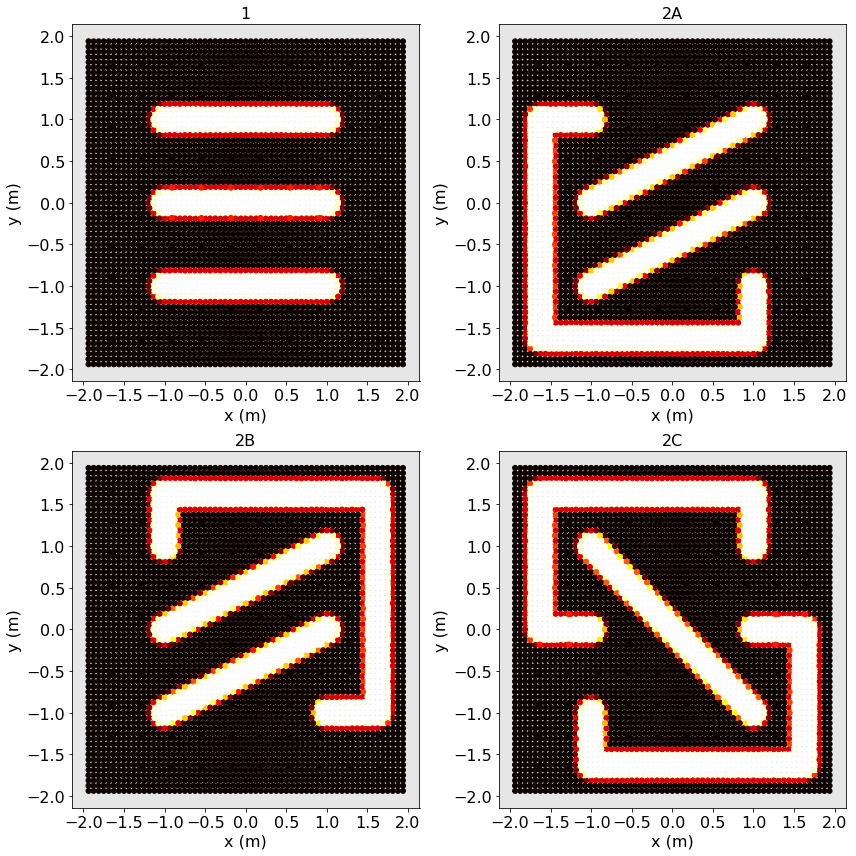

In [2]:
TRJ_SETS = [
    # 1
    [[(-1, 1), (1, 1)], [(-1, 0), (1, 0)], [(-1, -1), (1, -1)]],

    # 2A
    [
        [(-1, 1), (-1.625, 1), (-1.625, -1.625), (1, -1.625), (1, -1)],
        [(-1, 0), (1, 1)],
        [(-1, -1), (1, 0)],
    ],
    
    # 2B
    [
        [(-1, 1), (-1, 1.625), (1.625, 1.625), (1.625, -1), (1, -1)],
        [(-1, 0), (1, 1)],
        [(-1, -1), (1, 0)],
    ],
    
    # 2C
    [
        [(-1, 1), (1, -1)],
        [(-1, 0), (-1.625, 0), (-1.625, 1.625), (1, 1.625), (1, 1)],
        [(-1, -1), (-1, -1.625), (1.625, -1.625), (1.625, 0), (1, 0)],
    ]
]

# test multi-trj veil construction function
s = copy(S)
s['RNG_SEED'] = 0

ntwks = []

for trjs in TRJ_SETS:
    s['TRJ'] = trjs
    ## build trajectory
    trj = smln.build_trjs(s)
    schedule = s['schedule']

    ## adjust schedule
    t = np.arange(0, schedule['D_SMLN'], s['DT'])

    ## build ntwk
    ntwk = smln.build_ntwk(M, s)

    ## get apx. real-valued mask ("veil") over trj nrns;
    ## values are >= 0 and correspond to apx. scale factors on
    ## corresponding G->PC weights minus 1
    trj_veil = smln.get_trj_veil(trj, ntwk, M, s)
    ntwk.sgm = trj_veil + 1
    
    ntwks.append(ntwk)

# show veil
fig, axs = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)
titles = ['1', '2A', '2B', '2C']

for ax, ntwk, title in zip(axs.flatten(), ntwks, titles):
    ax.scatter(ntwk.pfxs, ntwk.pfys, c=ntwk.sgm, cmap='hot', s=25)
    ax.set_facecolor((.9, .9, .9))

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title(title)

    set_font_size(ax, 16)